In [4]:
'''Required Libraries'''
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import scipy
import sympy

import warnings
warnings.filterwarnings("ignore")
np.random.seed(int(np.random.rand(1)[0]*1000))

In [5]:
'''Helper Functions'''

# outputs the ground state, energy of input Hamiltonian
# format : (statevector, eigenvalue)
def ground_state(H):
    'H : Matrix form of Hamiltonian (array)'
    H = scipy.sparse.csr_matrix(H)
    eigvals, eigvecs = scipy.sparse.linalg.eigs(H)
    return eigvecs[:, np.argmin(eigvals)], np.real(min(eigvals))

# provides the matrix representation of Pauli-List (eg:'XXZ')
def operator(pauli):
    'Pauli : (string)'
    ops = {'I':np.array([[1,0],[0,1]]),
           'X':np.array([[0,1],[1,0]]),
           'Y':np.array([[0,-1j],[1j,0]]),
           'Z':np.array([[1,0],[0,-1]])}
    term = ops[pauli[0]]
    for i in range(1,len(pauli)):
        term = np.kron(term,ops[pauli[i]])
    return term

# returns the expectation value of the input observable with respect to the statevector
def expectation(obs,sv):
    'obs : Observable Matrix (array)'
    'sv  : Statevector (array)'
    return np.matmul(sv,np.matmul(obs,sv.conj().T)).round(5)

# initiates a statevector in state |00..0>
def initiate(n):
    'n : number of qubits/fermions (int)'
    sv = np.zeros(2**n)
    sv[0]=1
    return sv.T

# classical shadow(snapshots) of ground state of input Hamiltonian
def groundstate_shadow(num_snaps,H):
    'num_snaps : number of snapshots (more snapshots -> high computational cost along with high accuracy)'
    'H : Matrix form of Hamiltonian (array)'
    state,v = ground_state(H)
    num_qubits = int(np.log2(len(H)))
    
    dev = qml.device("default.qubit", wires=num_qubits,shots=1)
    @qml.qnode(dev)
    def circuit(state,obs):
        state = state/np.linalg.norm(state)
        qml.QubitStateVector(state, wires=range(num_qubits))
        return [qml.expval(o) for o in obs]
    
    shadow = classical_shadow(circuit,state,num_snaps,num_qubits)
    return shadow

# provides the reduced density matrix of the input density matrix considering a partition between qubits
def partial_trace(rho, keep, dims, optimize=False):
    keep = np.asarray(keep)
    dims = np.asarray(dims)
    Ndim = dims.size
    Nkeep = np.prod(dims[keep])

    idx1 = [i for i in range(Ndim)]
    idx2 = [Ndim+i if i in keep else i for i in range(Ndim)]
    rho_a = rho.reshape(np.tile(dims,2))
    rho_a = np.einsum(rho_a, idx1+idx2, optimize=optimize)
    return rho_a.reshape(Nkeep, Nkeep)

# calculates the Entanglement Entropy between sub-systems
def entanglement_entropy(sv,n):
    rho = np.outer(sv.conj().T, sv)
    dims = np.log2(len(sv))
    ndim = [2 for i in range(int(dims))]
    rho = partial_trace(rho, n, ndim)
    return np.real((-1)*(np.trace(rho @ scipy.linalg.logm(rho))))

In [6]:
'''Classical Shadow Functions'''
# outputs a list of snapshot states
def classical_shadow(circuit,params,num_shadows,num_qubits):
    '''circuit     : Any Quantum Circuit containing the State
       params      : List of Parameters needed in the Quantum Circuit
       num_shadows : Number of snapshots to be extracted
       num_qubits  : Number of qubits used in the Circuit'''
    unitary = {0:qml.PauliX, 1:qml.PauliY, 2:qml.PauliZ}
    mat = np.random.randint(0,3,size=(num_shadows,num_qubits))
    exp = []
    for i in range(num_shadows):
        k = []
        for j in range(num_qubits):
            k.append(unitary[int(mat[i,j])](int(j)))
        exp.append(circuit(params,k).numpy())
    
    def snapshot_state(string,index):
            unitary = {0 : {-1 : (1/np.sqrt(2))*np.array([[1],[-1]]), 1 : (1/np.sqrt(2))*np.array([[1],[1]])},
                       1 : {-1 : (1/np.sqrt(2))*np.array([[1],[-1j]]), 1 : (1/np.sqrt(2))*np.array([[1],[1j]])},
                       2 : {-1 : np.array([[0],[1]]), 1 : np.array([[1],[0]])}}
            eye = np.array([[1,0],[0,1]])
            state = []
            for i in range(len(string)):
                term = unitary[index[i]][string[i]]
                state.append(3*np.matmul(term,term.conj().T) - eye)
    
            ans = state[0]
            for j in range(1,len(string)):
                ans = np.kron(ans,state[j])
            return ans
    
    snaps = []
    for i in range(num_shadows):
        snaps.append(snapshot_state(exp[i],mat[i]))
    return snaps

# reconstructs a state density matrix of input shadow(list of snapshots) 
def reconstructed_state(shadow):
    '''Shadow : List of classical shadows of the state to be reconstructed'''
    num_snapshots = len(shadow)
    num_qubits = int(np.log2(len(shadow[0])))
    state = np.zeros((2**num_qubits, 2**num_qubits),dtype=complex)
    for i in range(num_snapshots):
        state += shadow[i]
    return state/num_snapshots

# provides an approximate observable expectation value
def obs_prediction(obs,shadow,K):
    '''obs    : Observable to be predicted (Matrix form)
       shadow : List of shadows
       K      : number of partitions'''
    N = len(shadow)
    qubits = int(np.log2(len(shadow[0])))
    num = int(np.floor(N/K))
    
    k = 0
    rho = []
    for i in range(K):
        term = np.zeros((2**qubits,2**qubits),dtype=complex)
        for j in range(num):
            term += shadow[k]
            k+=1
        rho.append((1/num)*term)
        
    exp = []
    for i in rho:
        exp.append(np.trace(np.matmul(obs,i)))
    return np.real(np.median(exp))

In [11]:
'''The Heisenberg Spin Model'''
# outputs the matrix corresponding to the Hamiltonian of the Heisenberg spin model with input coupling matrix J
def HeisenbergModel(J):
    N = len(J)
    edges = []
    for i in range(N):
        for j in range(i):
            edges.append([j,i])
    
    iden = 'I'
    for i in range(N-2):
        iden+='I'
        
    global H_terms 
    H_terms = []
    H = np.zeros((2**N,2**N),dtype=complex)
    for term in edges:
        for m in ['X','Y','Z']:
            K = iden[:term[0]]+m+iden[term[0]+1:term[1]]+m+iden[term[1]:]
            H = H + J[term[0]][term[1]]*operator(K)
            if J[term[0]][term[1]]!=0:
                H_terms.append(K)
    return H

# outputs a random coupling matrix corresponding to input model configuration
def J(row,col):
    edges = []
    k = np.array([[i+j*col for i in range(col)] for j in range(row)])
    for j in range(row):
        for i in range(col-1):
            edges.append((k[j][i],k[j][i+1]))

    for j in range(col):
        for i in range(row-1):
            edges.append((k[i][j],k[i+1][j]))

    mat = np.zeros((row*col,row*col))
    for i,j in edges:
        k = np.random.rand(1)[0] - 0.5
        mat[i,j] = k
        mat[j,i] = k
    return mat

# this function gives the correlation matrix calculated on the ground statevector obtained using Exact Diagonalization
# (the ground state property that we will be focusing on predicting)
def corr_mat(H):
    num_qubits = int(np.log2(len(H)))
    matrix = np.zeros((num_qubits,num_qubits), dtype=complex)
    state,value = ground_state(H)
    
    global J_terms
    J_terms = []
    
    def correlationfn(i,j,N):
        C=np.zeros((2**N,2**N),dtype=complex)
        term = ['I','I','I']
        for k in range(N):
            if (i==k+1 or j==k+1) and i!=j: 
                term[0]+='X'
                term[1]+='Y'
                term[2]+='Z'
            else: 
                term[0]+='I'
                term[1]+='I'
                term[2]+='I'
        term = [term[0][1:],term[1][1:],term[2][1:]]
        if i!=j:
            J_terms.append(term)
        for i in term: C += operator(i)
        return (1/3)*C
    
    for i in range(num_qubits):
        for j in range(num_qubits):
            op = correlationfn(i+1,j+1,num_qubits)
            matrix[i,j] = expectation(op,state)
    return matrix

# The approximate correlation matrix constructed using the prediction algortihm of classical shadows
def shadow_corr(num_shots,H):
    num_qubits = int(np.log2(len(H)))
    matrix = np.zeros((num_qubits,num_qubits), dtype=complex)
    shad = groundstate_shadow(num_shots,H)
    
    def correlationfn(i,j,N):
        C=np.zeros((2**N,2**N),dtype=complex)
        term = ['I','I','I']
        for k in range(N):
            if (i==k+1 or j==k+1) and i!=j: 
                term[0]+='X'
                term[1]+='Y'
                term[2]+='Z'
            else: 
                term[0]+='I'
                term[1]+='I'
                term[2]+='I'
        term = [term[0][1:],term[1][1:],term[2][1:]]
        for i in term: C += operator(i)
        return (1/3)*C

    for i in range(num_qubits):
        for j in range(num_qubits):
            op = correlationfn(i+1,j+1,num_qubits)
            matrix[i,j] = obs_prediction(op,shad,5)
    return matrix

In [12]:
j = J(3,3)
H = HeisenbergModel(j)
s,v = ground_state(H)
print('GSE:',v)
corr= np.real(corr_mat(H))
shad_corr = np.real(shadow_corr(1000,H))
shad = groundstate_shadow(1000,H)
obs = obs_prediction(H,shad,2)
print('Shadow Prediction of GSE:',obs)

GSE: -3.7979773502088667
Shadow Prediction of GSE: -3.8538089714185544


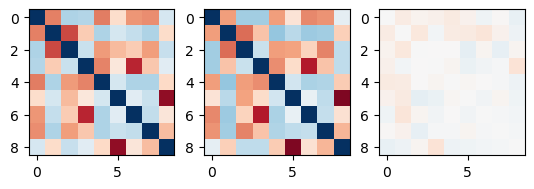

In [13]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(corr, cmap=plt.get_cmap("RdBu"), vmin = -1,vmax = 1)
axarr[1].imshow(shad_corr, cmap=plt.get_cmap("RdBu"), vmin = -1,vmax = 1)
axarr[2].imshow(corr-shad_corr, cmap=plt.get_cmap("RdBu"), vmin = -1,vmax = 1)

In [14]:
'''The 1D Ising Spin Chain in Transverse Field'''
# gives the matrix representation of the Hamiltonian of Ising Model of provided parameters
def IsingModel(J,h,N):
    terms = []
    for i in range(N-1):
        terms.append((i,i+1))
    terms.append((0,N-1))
    
    iden = 'I'
    for i in range(N-2):
        iden += 'I'
        
    Hj = np.zeros((2**N,2**N), dtype=complex)
    for i,j in terms:
        Hj = Hj + (-1)*J*operator(iden[:i]+'Z'+iden[i+1:j]+'Z'+iden[j:])
    
    iden+='I'
    Hh = np.zeros((2**N,2**N),dtype=complex)
    for i in range(N):
        Hh = Hh + (-1)*h*operator(iden[:i]+'X'+iden[i+1:])
    return np.real((Hj+Hh))

# gives the Jordan-Wigner spectrum of the Ising Model of provided parameters
def Ising_JW(J,h,N):
    mat = np.zeros((N,N))
    for i in range(N):
        mat[i,i] = (-2)*(h)
    for i in range(N-1):
        mat[i,i+1] = (-2)*(J)
    return mat

In [15]:
'''Random Quantum Circuits'''
# one block of random unitary, outputs the unitary matrix
def block(alpha,params,N):
    params = np.pi*(abs(params)/(np.max(abs(params))+np.min(abs(params))))
    iden = 'I'
    for i in range(N-3):
        iden+='I'
    
    terms = []
    for i in range(N-1):
        terms.append(scipy.linalg.expm(-1j*(np.pi/4)*operator(iden[:i]+alpha+alpha+iden[i:])))
    terms.append(scipy.linalg.expm(-1j*(np.pi/4)*operator(alpha+iden+alpha)))
    
    t = []
    iden+='I'
    for i in range(N):
        terms.append(scipy.linalg.expm(-1j*(np.pi/4)*operator(iden[:i]+'Z'+iden[i:])))
    for i in range(N):
        terms.append(scipy.linalg.expm(-1j*(params[N-(i+1)])*operator(iden[:i]+'X'+iden[i:])))
    
    mat = terms[0]
    for i in range(1,len(terms)):
        mat = np.matmul(terms[i],mat)
    return mat

def corr_matrix(c,var,n):
    mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            mat[i,j] = c*np.exp(-1*((i-j)**2)/2*(var**2))
    Q, D = sympy.Matrix(mat).diagonalize()
    M = np.matmul(np.array(Q).astype('float64'),scipy.linalg.sqrtm(np.array(D).astype('float64')))
    return M

In [ ]:
    n = 6
    #statevector = []
    SV = []
    for j in range(500):
        sv = initiate(n)
        corr_mat = corr_matrix(np.random.randint(1,6),np.random.rand(1)[0],n)
        steps = []
        vector = []
        for i in range(50):
            params = np.matmul(corr_mat,np.random.normal(0,0.5,n))
            unitary = block('Z',params,n)
            sv = np.matmul(unitary,sv)
            steps.append(i)
            vector.append(sv)
        if (j+1)%5 == 0:
            print('Iteration :',j+1)
        SV.append(vector)
    #statevector.append(SV)

In [16]:
import pickle
file = open("Z-circuit-8.pkl",'rb')
Z_circ_8 = pickle.load(file)

In [28]:
steps = [i for i in range(50)]

In [25]:
def obs_list(obs,circ):
    expecs = []
    for i in range(len(circ[0])):
        expec = []
        for j in range(len(circ)):
            expec.append(expectation(obs,circ[j][i]))
        expecs.append((1/8)*sum(np.array(expec)))
    return expecs

In [21]:
def magnet(n):
    z = 'Z'
    for i in range(n-1):
        z+='Z'
    return operator(z)

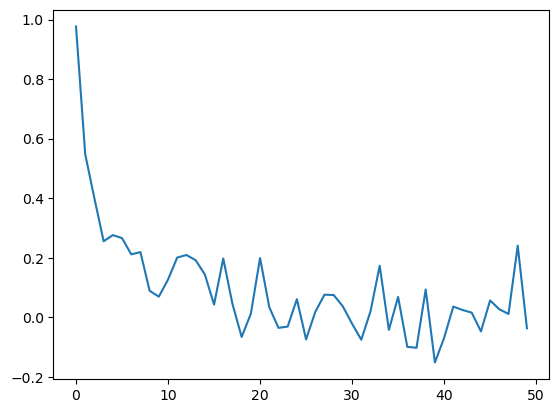

In [29]:
# Plot of evolution of magnetization observable
expec = obs_list(magnet(8),Z_circ_8)
plt.plot(steps,expec)